# Inference of the radial Z-effective profile

In this example, we demonstrate how the radial profile of Z-effective can be inferred by combining radial measurements of the electron temperature and density from a Thomson scattering diagnostic, and radial measurements of bremsstrahlung emission from a filtered imaging diagnostic.

First, lets import the synthetic data we've created for this example and plot it:

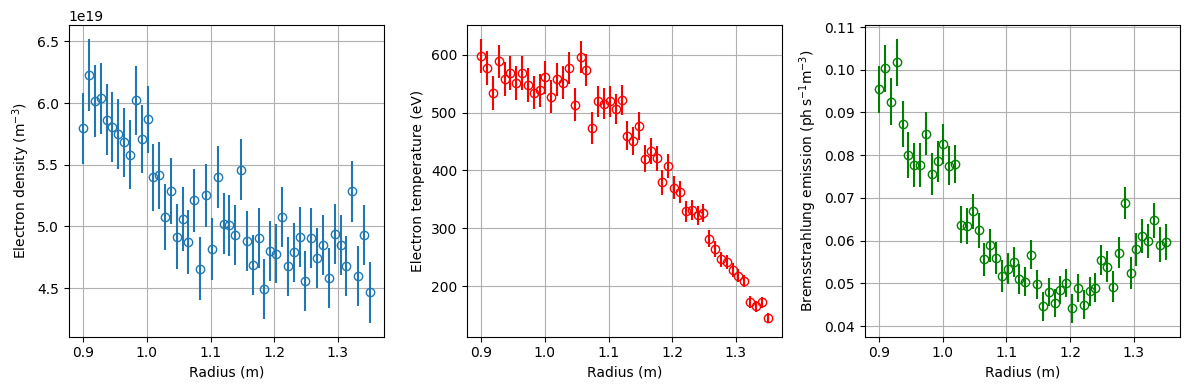

In [175]:
# import the synthetic diagnostic data and associated uncertainties
from example_data import brem_measurements, brem_sigma, measurement_radius
from example_data import te_measurements, ne_measurements, te_sigma, ne_sigma


import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

data_style = dict(marker="o", linestyle="none", markerfacecolor="none")

ax1.errorbar(measurement_radius, ne_measurements, yerr=ne_sigma, c="C0", **data_style)
ax1.set_xlabel("Radius (m)")
ax1.set_ylabel(r"Electron density $(\mathrm{m}^{-3})$")
ax1.grid()

ax2.errorbar(measurement_radius, te_measurements, yerr=te_sigma, c="red", **data_style)
ax2.set_xlabel("Radius (m)")
ax2.set_ylabel("Electron temperature (eV)")
ax2.grid()

ax3.errorbar(measurement_radius, brem_measurements, yerr=brem_sigma, c="green", **data_style)
ax3.set_xlabel("Radius (m)")
ax3.set_ylabel(r"Bremsstrahlung emission $(\mathrm{ph \, s^{-1} m^{-3})}$")
ax3.grid()

fig.tight_layout()
plt.show()

A MIDAS analysis follows the following steps:

 - Create a `DiagnosticLikelihood` instance for each diagnostic included in the analysis.

 - Create a `FieldModel` instance for each field which is requested by one of the diagnostic models.

 - Specify the prior distribution using classes from the `midas.priors` module (or implement your own using the `BasePrior` base-class).

 - Build the parametrisation for the posterior distribution by calling the `PlasmaState.build_posterior()` function.

 - Use the functions in the `midas.posterior` module to evaluate the posterior distribution, allowing for MAP estimation or sampling.


## Adding diagnostics to a MIDAS analysis

To include a diagnostic in a MIDAS analysis, we need to create a `DiagnosticLikelihood`
object. MIDAS abstracts the definition of a diagnostic likelihood into two parts:


* A `DiagnosticModel` object, which implements (or calls)
  the forward-model for the diagnostic, and specifies what information is required to
  evaluate the model predictions (e.g. the values of plasma fields like temperature or
  density at specific coordinates).


* A `LikelihoodFunction` object, which holds the experimental
  measurements and uncertainties, and specifies a distribution used to model the
  uncertainties (e.g. Gaussian, logistic etc.)


### Defining diagnostic models
In MIDAS, diagnostic models are classes which inherit from an abstract base-class `DiagnosticModel`. This class can fully implement a forward-model of a diagnostic, or act as a light wrapper around a model implemented elsewhere, allowing that model to interact with MIDAS.

In this example, we will use an existing physics code which models the bremsstrahlung emission $\mathcal{E}$ as
$$
\mathcal{E} = a Z_{\mathrm{eff}} n_e^2 \frac{G(T_e)}{\lambda^2 \sqrt{T_e}} \exp{\left[ - \frac{b}{\lambda T_e}\right]}.
$$
Here $a$, $b$ are known constants, and for simplicity we'll assume our bremsstrahlung measurements were collected at a single fixed wavelength $\lambda$.

Therefore, to make predictions of our measured bremsstrahlung, we need to specify the Z-effective $Z_{\mathrm{eff}}$, electron temperature $T_e$ and electron density $n_e$ at the appropriate radial positions.

To communicate to MIDAS that the values of these fields are required inputs to the model, we use the `self.fields` instance attribute of our model class. `self.fields` is always an instance of the `Fields` class, which accepts a series of `FieldRequests` as arguments. Each instance of `FieldRequest` allows us to request the values of a particular field at a given set of coordinates.

The `DiagnosticModel` base-class also has two abstract methods, `predictions` and `predictions_and_jacobians`, which MIDAS will call when evaluating the posterior log-probability or its derivative. The values of any fields or parameters required by the model are passed to these methods using the names of the fields and parameters.

We can now implement a diagnostic model for the Bremsstrahlung measurements as follows:

In [146]:
# import our existing physics model
from diagnostics import bremsstrahlung_model, bremsstrahlung_jacobian

# import the midas components that we'll need to build a diagnostic model
from midas import Fields, FieldRequest, Parameters
from midas.models import DiagnosticModel

from numpy import ndarray


class BremsstrahlungModel(DiagnosticModel):
    def __init__(self, radius: ndarray, wavelength: float):
        self.wavelength = wavelength

        # Set the 'fields' attribute to request the field values the model needs
        self.fields = Fields(
            FieldRequest(name="te", coordinates={"radius": radius}),
            FieldRequest(name="ne", coordinates={"radius": radius}),
            FieldRequest(name="z_eff", coordinates={"radius": radius}),
        )

        # The model has no additional parameters, so the self.parameters instance
        # attribute is set to an empty instance of the 'Parameters' class.
        self.parameters = Parameters()

    def predictions(self, te: ndarray, ne: ndarray, z_eff: ndarray) -> ndarray:
        # We set the arguments of the predictions function to be the names of
        # the fields we requested using the self.fields instance attribute.

        # now we have access to all the information needed to call the physics
        # model and return its output.
        return bremsstrahlung_model(
            Te=te,
            Ne=ne,
            zeff=z_eff,
            wavelength=self.wavelength,
        )

    def predictions_and_jacobians(
            self, te: ndarray, ne: ndarray, z_eff: ndarray
    ) -> tuple[ndarray, dict[str, ndarray]]:
        # this function must return the predictions and the jacobians of the
        # predictions, i.e. the derivative of each prediction value with
        # respect to each input value.

        # call our physics model to get the predictions and the jacobians
        predictions, te_jac, ne_jac, z_eff_jac = bremsstrahlung_jacobian(
            Te=te,
            Ne=ne,
            zeff=z_eff,
            wavelength=self.wavelength,
        )

        # we return the jacobians as a dictionary mapping the input names to
        # their respective jacobian matrix.
        jacobians = {
            "te": te_jac,
            "ne": ne_jac,
            "z_eff": z_eff_jac,
        }

        return predictions, jacobians


Now we've defined our bremsstrahlung model class, we can create an instance of it to be used by MIDAS:

In [147]:
brem_forward_model = BremsstrahlungModel(
    radius=measurement_radius,
    wavelength=569e-9,
)


### Choosing a likelihood function for a diagnostic
In MIDAS, a `LikelihoodFunction` specifies the model which will be used for the uncertainties associated with the measured data. The `midas.likelihoods` module contains classes for several common distributions - here we'll model the data uncertainties as Gaussian:

In [148]:
from midas.likelihoods import GaussianLikelihood

`LikelihoodFunction` classes take the measured data and the uncertainty values as inputs:

In [149]:
brem_likelihood = GaussianLikelihood(
    y_data=brem_measurements,
    sigma=brem_sigma,
)

Now we have built the two necessary components, we can create a `DiagnosticLikelihood` instance to represent our bremsstrahlung diagnostic:

In [150]:
from midas.likelihoods import DiagnosticLikelihood

brem_diagnostic = DiagnosticLikelihood(
    likelihood=brem_likelihood,
    diagnostic_model=brem_forward_model,
    name="brem_diagnostic"
)

We can now repeat this process and create `DiagnosticLikelihood` instances to represent diagnostic models for the electron temperature and density data:

In [151]:
# for brevity, here we import a model for the Thomson scattering profile data
from diagnostics import ThomsonModel

# build the electron temperature diagnostic likelihood
te_likelihood = GaussianLikelihood(
    y_data=te_measurements,
    sigma=te_sigma,
)

te_forward_model = ThomsonModel(
    radius=measurement_radius,
    field="te"
)

te_diagnostic = DiagnosticLikelihood(
    likelihood=te_likelihood,
    diagnostic_model=te_forward_model,
    name="te_diagnostic"
)

# build the electron density diagnostic likelihood
ne_likelihood = GaussianLikelihood(
    y_data=ne_measurements,
    sigma=ne_sigma,
)

ne_forward_model = ThomsonModel(
    radius=measurement_radius,
    field="ne"
)

ne_diagnostic = DiagnosticLikelihood(
    likelihood=ne_likelihood,
    diagnostic_model=ne_forward_model,
    name="ne_diagnostic"
)

## Adding prior constraints
The `midas.priors` module contains common distributions you might use to impose a prior on a particular parameter or field value, such as the Gaussian, exponential and Beta distributions. Custom prior distributions can be easily created by writing a class which inherits from the `midas.priors.BasePrior` abstract base-class.

Here we show an example of how to impose a more sophisticated constraint - that the electron temperature profile should decrease monotonically over the range of radii for which we are inferring its values.

We achieve this using the `SoftLimitPrior`, which imposes a Gaussian prior on a chosen set of values only when those values go above a specified limit:

In [152]:
from midas.priors import SoftLimitPrior

We can specify the values to which the `SoftLimitPrior` is applied using a `FieldRequest`, and optionally we can specify a linear operator which be applied to those field values before they are acted on by the prior.

If we choose our linear operator such that it calculates the derivative of the electron temperature profile, and set our upper-limit for the prior to be zero, the `SoftLimitPrior` will encourage solutions where the temperature gradient is negative everywhere, yielding the desired monotonicity of the profile.

The `derivative_operator` function from the `midas.operators` module allows us to easily create such a derivative operator:

In [153]:
from midas.operators import derivative_operator
operator = derivative_operator(measurement_radius, order=1)

Now set up a `FieldRequest` for the temperature values and create the `SoftLimitPrior` instance:

In [154]:
te_request = FieldRequest(name="te", coordinates={"radius": measurement_radius})

te_monotonicity_prior = SoftLimitPrior(
    name="te_monotonicity_prior",
    field_request=te_request,
    upper_limit=0.0,
    standard_deviation=30.,
    operator=operator
)

## Specifying models for the requested fields
As our diagnostic models and priors require information about particular plasma fields we need to specify models which parametrise those fields in some way.

The `midas.models.fields` module has various built-in models for fields, and custom field models can be implemented using the `FieldModel`, abstract base-class.

For Z-effective we will use `CubicSplineField`, which uses an interpolating cubic spline to model a 1D field:

In [155]:
from numpy import linspace
from midas.models.fields import CubicSplineField

# choose positions for the spline knots
z_eff_knots = linspace(0.9, 1.35, 5)

# build the field model for Z-effective
z_eff_field = CubicSplineField(
    field_name="z_eff",
    axis=z_eff_knots,
    axis_name="radius"
)


For the electron temperature and density fields we'll use `ExSplineField`, which uses an exponentiated sum of B-splines to model a 1D field. This model has the advantage of guaranteeing positive values of the field do to the exponentiation:

In [156]:
from midas.models.fields import ExSplineField

ts_knots = linspace(0.9, 1.35, 6)
ne_field = ExSplineField(
    field_name="ne",
    axis_name="radius",
    axis=ts_knots,
)

te_field = ExSplineField(
    field_name="te",
    axis_name="radius",
    axis=ts_knots,
)

## Building the posterior
The final step in specifying the posterior distribution is to pass our collected diagnostic likelihoods, prior distributions and field models to `PlasmaState.build_posterior`:

In [157]:
from midas import PlasmaState

PlasmaState.build_posterior(
    diagnostics=[brem_diagnostic, te_diagnostic, ne_diagnostic],
    priors=[te_monotonicity_prior],
    field_models=[te_field, ne_field, z_eff_field]
)

Calling `PlasmaState.build_posterior` builds the parametrisation for the posterior distribution, which means we can now import the `posterior` module, which contains functions for evaluating evaluating the posterior log-probability and its derivative:

In [158]:
from midas import posterior

## MAP estimation
Now we are able to evaluate the posterior, the next step is to find the model parameters which maximise the posterior probability.

We can view the names of the parameters in the `PlasmaState.parameter_names` tuple, or both the names and sizes in the `PlasmaState.parameter_sizes` dictionary:

In [159]:
PlasmaState.parameter_sizes

{'ln_ne_bspline_basis': 6, 'ln_te_bspline_basis': 6, 'z_eff_cubic_spline': 5}

As optimisers and MCMC samplers typically require the parameter values as a single `numpy.ndarray`, `PlasmaState` has methods for converting between dictionaries mapping parameter names to values and the required arrays.

Here we use the `PlasmaState.merge_parameters` method to build an initial guess array for the optimisation:

In [160]:
from numpy import full, log

initial_guess_dict = {
    'ln_ne_bspline_basis': full(ts_knots.size, fill_value=log(5e19)),
    'ln_te_bspline_basis': full(ts_knots.size, fill_value=log(60.)),
    'z_eff_cubic_spline': full(z_eff_knots.size, fill_value=1.2),
}
initial_guess_array = PlasmaState.merge_parameters(initial_guess_dict)

We can evaluate the posterior log-probability of our initial guess using the `posterior.log_probability` function:

In [161]:
print(f"initial guess log-prob {posterior.log_probability(initial_guess_array):.2f}")

initial guess log-prob -9027.68


We can use the `PlasmaState.build_bounds` method construct an array of lower and upper bounds for the parameters which can be given to the optimiser:

In [162]:
bounds_dict = {
    'ln_ne_bspline_basis': (log(1e17), log(1e21)),
    'ln_te_bspline_basis': (log(2), log(1000)),
    'z_eff_cubic_spline': (1.0, 5.0),
}

bounds = PlasmaState.build_bounds(bounds_dict)

As most optimisers are set up to _minimise_ the value of a function, the `posterior` module has `cost` and `cost_gradient` functions which return the negative of the log-probability and its gradient respectively. We can pass these functions to a gradient-based optimiser along with the bounds and intial guess:

In [163]:
from scipy.optimize import minimize

opt_result = minimize(
    fun=posterior.cost,
    x0=initial_guess_array,
    method='L-BFGS-B',
    bounds=bounds,
    jac=posterior.cost_gradient,
)

# extract the MAP estimate parameters from the results
map_estimate_params = opt_result.x

# verify that the MAP parameters yield a higher log-probability than the initial guess
print(f"initial guess log-prob {posterior.log_probability(initial_guess_array):.2f}")
print(f" MAP estimate log-prob {posterior.log_probability(map_estimate_params):.2f}")

initial guess log-prob -9027.68
 MAP estimate log-prob -2195.99


The `posterior.get_model_predictions` returns a dictionary mapping the name of each diagnostic to the predictions of that diagnostic's data for a given set of model parameters. Here we pass the MAP estimate parameters so we can compare the MAP predictions to the synthetic data:

In [164]:
map_predictions = posterior.get_model_predictions(map_estimate_params)

# check the diagnostic names
{name for name in map_predictions.keys()}

{'brem_diagnostic', 'ne_diagnostic', 'te_diagnostic'}

Now plot the MAP estimate predictions together with the synthetic data:

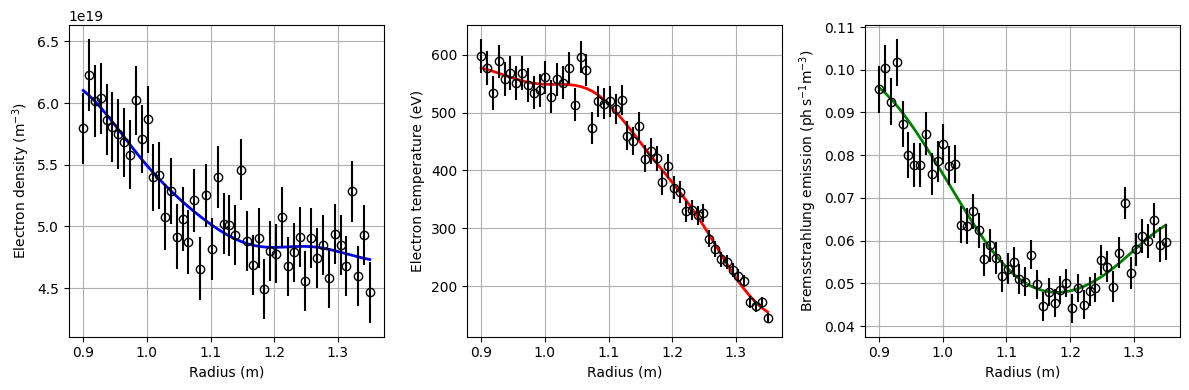

In [176]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

data_style = dict(marker="o", linestyle="none", markerfacecolor="none", color="black")

ax1.plot(measurement_radius, map_predictions["ne_diagnostic"], color="blue", lw=2)
ax1.errorbar(measurement_radius, ne_measurements, yerr=ne_sigma, **data_style)
ax1.set_xlabel("Radius (m)")
ax1.set_ylabel(r"Electron density $(\mathrm{m}^{-3})$")
ax1.grid()

ax2.plot(measurement_radius, map_predictions["te_diagnostic"], color="red", lw=2)
ax2.errorbar(measurement_radius, te_measurements, yerr=te_sigma, **data_style)
ax2.set_xlabel("Radius (m)")
ax2.set_ylabel("Electron temperature (eV)")
ax2.grid()

ax3.plot(measurement_radius, map_predictions["brem_diagnostic"], c="green", lw=2)
ax3.errorbar(measurement_radius, brem_measurements, yerr=brem_sigma, **data_style)
ax3.set_xlabel("Radius (m)")
ax3.set_ylabel(r"Bremsstrahlung emission $(\mathrm{ph \, s^{-1} m^{-3})}$")
ax3.grid()

fig.tight_layout()
plt.show()

## Uncertainty quantification using MCMC
To characterise the uncertainies in our model parameters we will sample from the posterior distribution using Hamiltonian Monte Carlo (HMC), an MCMC algorithm which can efficiently sample from high-dimensional posterior distributions, but requires calculation of the gradient of the posterior log-probability.

MIDAS has been intentionally designed to be easily used with external packages for optimisation and sampling. Here we use the [inference-tools](https://github.com/C-bowman/inference-tools) package to perform the HMC sampling.

First we get the variance of the conditional distribution for each model parameter around the MAP estimate using the `conditional_moments` function from the `inference.approx` module:

In [166]:
from inference.approx import conditional_moments

_, conditional_variance = conditional_moments(
    posterior=posterior.log_probability,
    conditioning_point=map_estimate_params,
    bounds=[b for b in bounds],
)

These conditional distribution variances are given as an optional argument to the `HamiltonianChain` class to improve the sampling efficiency (see the [inference-tools docs](https://inference-tools.readthedocs.io/en/stable/HamiltonianChain.html) for details).

Now we can create an instance of the HMC sampler:

In [167]:
from inference.mcmc import HamiltonianChain

chain = HamiltonianChain(
    posterior=posterior.log_probability,
    grad=posterior.gradient,
    start=map_estimate_params,
    inverse_mass=conditional_variance,
    bounds=(bounds[:, 0], bounds[:, 1]),
    epsilon=0.25,
    simulation_steps=15
)

To perform the sampling we advance the Markov-chain a given number of steps:

In [168]:
chain.advance(5000)

  advancing chain:   [ complete - 5000 steps taken in 0:00:10 ]      


We can use the `plot_diagnostics` method of markov-chain objects to view key diagnostics of the sampling:

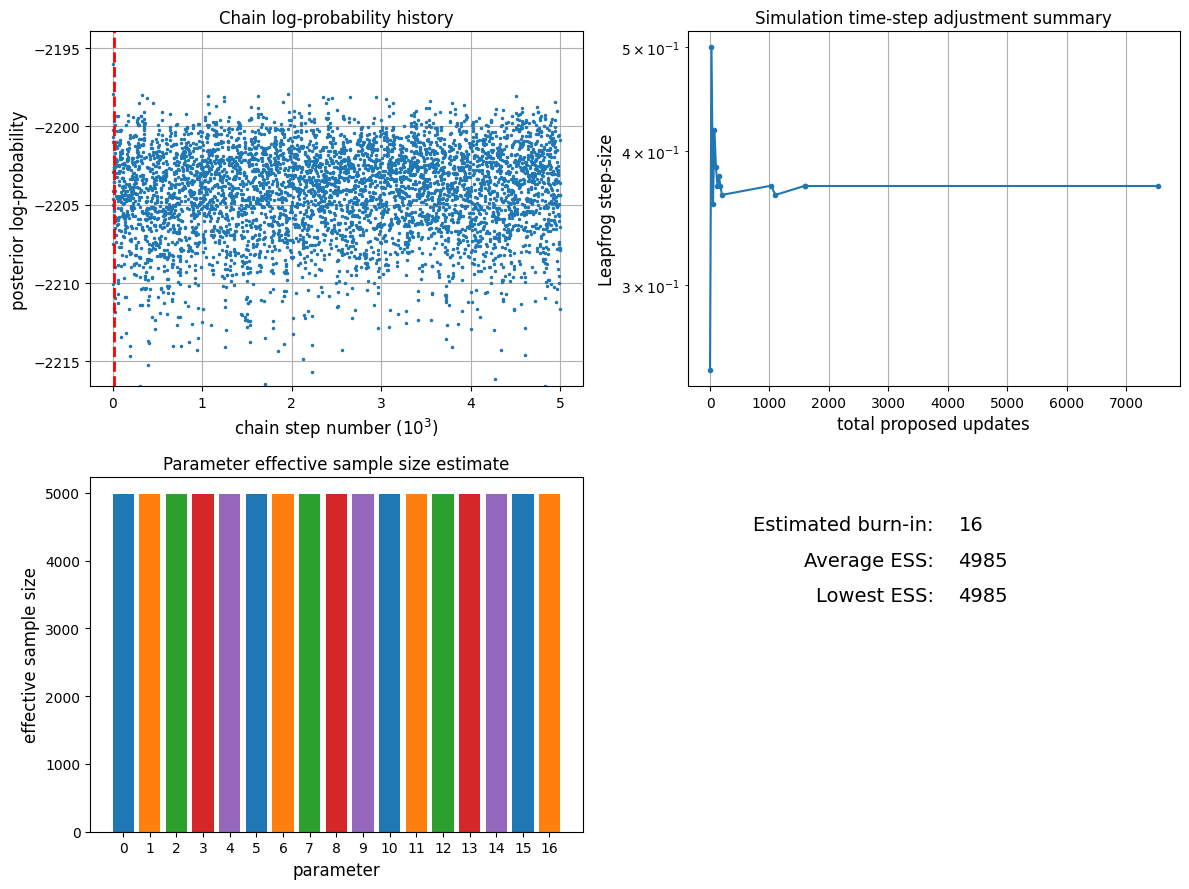

In [169]:
chain.plot_diagnostics()

We can retreive the sample data from the chain using the `get_sample` method:

In [170]:
sample = chain.get_sample(burn=500, thin=1)

The `sample_field_values` function from the `midas.posterior` module provides an easy way to calculate the set of field values corresponding to a set of parameter samples:

In [171]:
# chose a set of radius positions where the fields will be evaluated
profile_axis = linspace(0.9, 1.35, 128)

# Calculate the field profiles for each parameter sample
te_profiles = posterior.sample_field_values(
    parameter_samples=sample,
    field_request=FieldRequest("te", coordinates={"radius": profile_axis}),
)

ne_profiles = posterior.sample_field_values(
    parameter_samples=sample,
    field_request=FieldRequest("ne", coordinates={"radius": profile_axis}),
)

z_eff_profiles = posterior.sample_field_values(
    parameter_samples=sample,
    field_request=FieldRequest("z_eff", coordinates={"radius": profile_axis}),
)

Import the true profiles of the fields used to generate the synthetic data so we can compare them with the inferred profiles:

In [172]:
from example_data import true_z_eff_profile, true_te_profile, true_ne_profile

The `hdi_plot` function from `inference-tools` is a convenient way to plot a set of sampled curves in terms of their mean and highest-density intervals:

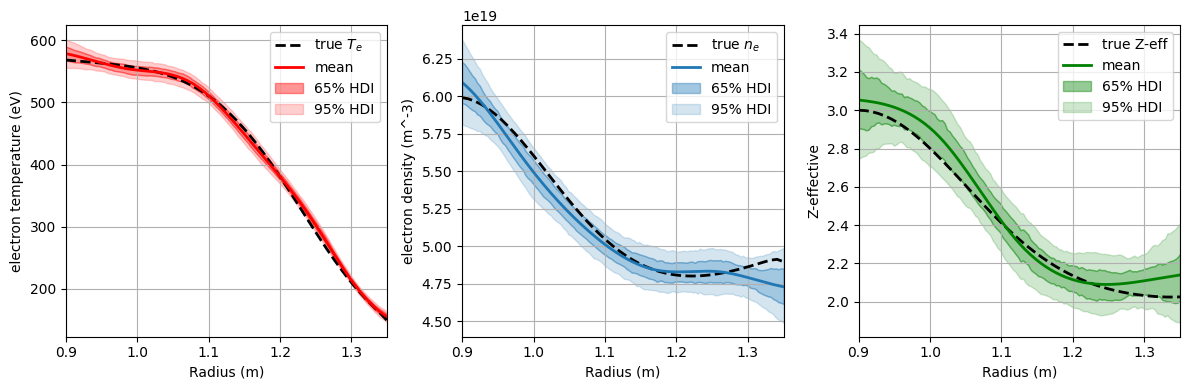

In [173]:
from inference.plotting import hdi_plot

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot(measurement_radius, true_te_profile, lw=2, color="black", ls="dashed", label=r"true $T_e$")
hdi_plot(profile_axis, te_profiles, axis=ax1, color="red")
ax1.set_xlabel("Radius (m)")
ax1.set_ylabel("electron temperature (eV)")
ax1.set_xlim([0.9, 1.35])
ax1.grid()
ax1.legend()

ax2.plot(measurement_radius, true_ne_profile, lw=2, color="black", ls="dashed", label=r"true $n_e$")
hdi_plot(profile_axis, ne_profiles, axis=ax2, color="C0")
ax2.set_xlabel("Radius (m)")
ax2.set_ylabel("electron density (m^-3)")
ax2.set_xlim([0.9, 1.35])
ax2.grid()
ax2.legend()

ax3.plot(measurement_radius, true_z_eff_profile, lw=2, color="black", ls="dashed", label="true Z-eff")
hdi_plot(profile_axis, z_eff_profiles, axis=ax3, color="green")
ax3.set_xlabel("Radius (m)")
ax3.set_ylabel("Z-effective")
ax3.set_xlim([0.9, 1.35])
ax3.grid()
ax3.legend()

plt.tight_layout()
plt.show()

Neither of the two diagnostics we've included in the problem directly measure Z-effective, and it cannot be calculated from the measurements of either diagnostic by themselves. However, by combining the information from both diagnostics and analysing their data simultaneously, we are able to infer the profile of Z-effective - this is a powerful advantage of the multi-instrument Bayesian data analysis approach which MIDAS is designed to enable.